In this notebook, we are going to follow [How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) and [Inceptionism: Going Deeper into Neural Networks ](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) to try to see what happens when we use an existing image recognition system to create an image that has a high probability of being recognized as something it knows.

We will use vgg16 for the network in this notebook and save inception for another try.

In [2]:
# Load the dependencies and the pre-trained vgg16 model.  

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K

import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display

# build the VGG16 network with ImageNet weights
#  This time, we load the complete model, not just the conv layers.

vgg = vgg16.VGG16(weights='imagenet', include_top=True)
print('Model loaded.')
vgg.summary()


Using TensorFlow backend.
W0706 14:36:19.106598 139660494485312 deprecation_wrapper.py:119] From /home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0706 14:36:19.115897 139660494485312 deprecation_wrapper.py:119] From /home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0706 14:36:19.117198 139660494485312 deprecation_wrapper.py:119] From /home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0706 14:36:19.134268 139660494485312 deprecation_wrapper.py:119] From /home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is dep

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0      

In [18]:
# we will also use the end labels in order to pick maximum values
import json

with open('../vgg16classes.json', 'r') as f:
    blob = json.load(f)
    
vgg16_dict = {v[1]:int(k) for k,v in blob.items()}

print(list(vgg16_dict.items())[:10])

[('tench', 0), ('goldfish', 1), ('great_white_shark', 2), ('tiger_shark', 3), ('hammerhead', 4), ('electric_ray', 5), ('stingray', 6), ('cock', 7), ('hen', 8), ('ostrich', 9)]


```vgg16_dict``` gives us a dictionary that maps a text name of an object to the index of the vgg16 class that represents pictures of that object.  By maximizing the probability that vgg16 sees a particular class, we can invent pictures of these classes of objects (according to the network).

W0707 19:25:03.466675 139660494485312 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


6


/home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


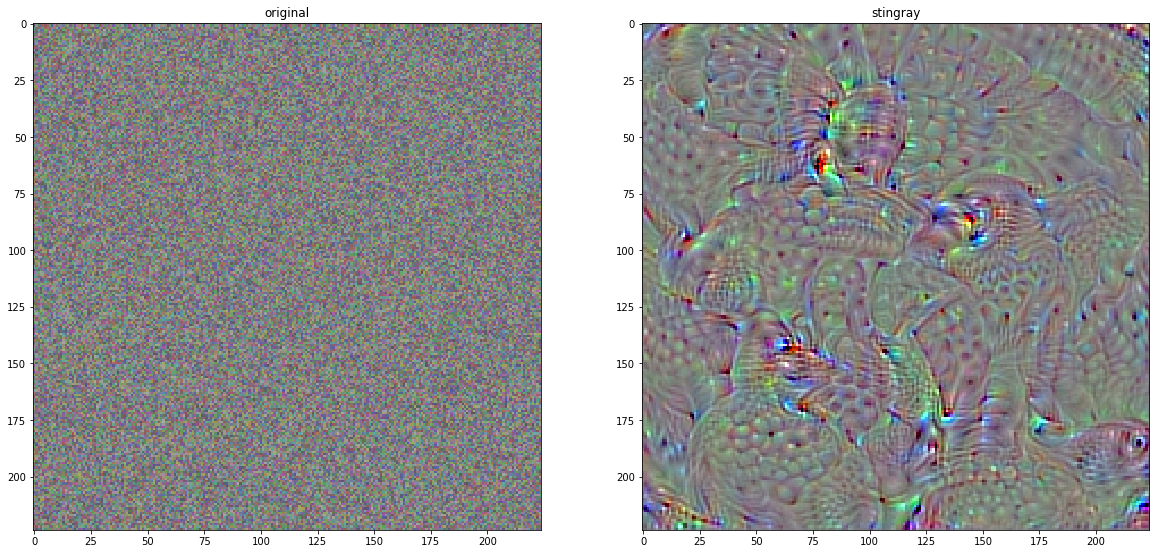

In [40]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8', casting='unsafe')
    return x

def step_output(model, output_layer_dict, output_index, img):
    # calculate cummulative L_1 loss
    loss = K.variable(0.)
    for item in output_layer_dict.items():
        layer = get_layer_by_name(model, item[0])
        weight = item[1]
        # accumulate te L_1 loss over the specified layers using the defined weights.
        scaling = K.prod(K.cast(K.shape(output_layer.output), 'float32'))
        loss += weight * K.mean(output_layer.output[:, :, :, :]) #/scaling

    loss += K.mean(model.output[:, output_index])
    # make gradients
    grads = K.gradients(loss, model.inputs[0])[0]
    grads =  grads / (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

    step = K.function([model.inputs[0]], [loss, grads])

    return step([img])
    
def get_layer_by_name(model, layer_name):
    # use model.summary to see the layer names.
    layer_dict = dict([(layer.name, layer) for layer in vgg.layers[1:]])

    if layer_name in layer_dict:
        return layer_dict[layer_name]
    else: return None

def get_random_filter(model, layer):
    # get a filter from model
    filter_upper = len(layer.get_weights()[1])

    assert(filter_upper > 0)

    # pick a random filter index
    return np.random.randint(filter_upper)

    
#test
output_layer = get_layer_by_name(vgg, 'block5_conv3')
assert isinstance(output_layer, layers.Conv2D)

#idx = get_random_filter(vgg, output_layer)
#print(idx)

#select an output class (chicken, for example)
named_obj = 'stingray'
out_index = vgg16_dict[named_obj]
print(out_index)

# create an image for the input.
input_img_data = np.random.random((1, 224, 224, 3))

# map layer names to a weight to apply to the loss
layer_dict = {
    'block5_conv1':0.3,
    'block5_conv2':0.7,
    'block5_conv3':1.1
}

# now create a function to iterate the gradients to add to the image.
def iterate_grads(model, layer_dict, filter_index, iterations, img):
    next_image = img
    for _ in range(iterations):
        losses, gradients = step_output(model, layer_dict, filter_index, next_image)
        next_image = next_image + gradients
    return next_image

iter = 20
final_img = iterate_grads(vgg,  layer_dict, out_index, iter, input_img_data)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))

ax1.imshow(deprocess_image(input_img_data.reshape(224,224,3)))
ax1.set_title('original')
ax2.imshow(deprocess_image(final_img.reshape(224,224,3)))
ax2.set_title(named_obj)
fig.show()

76
85
64


/home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


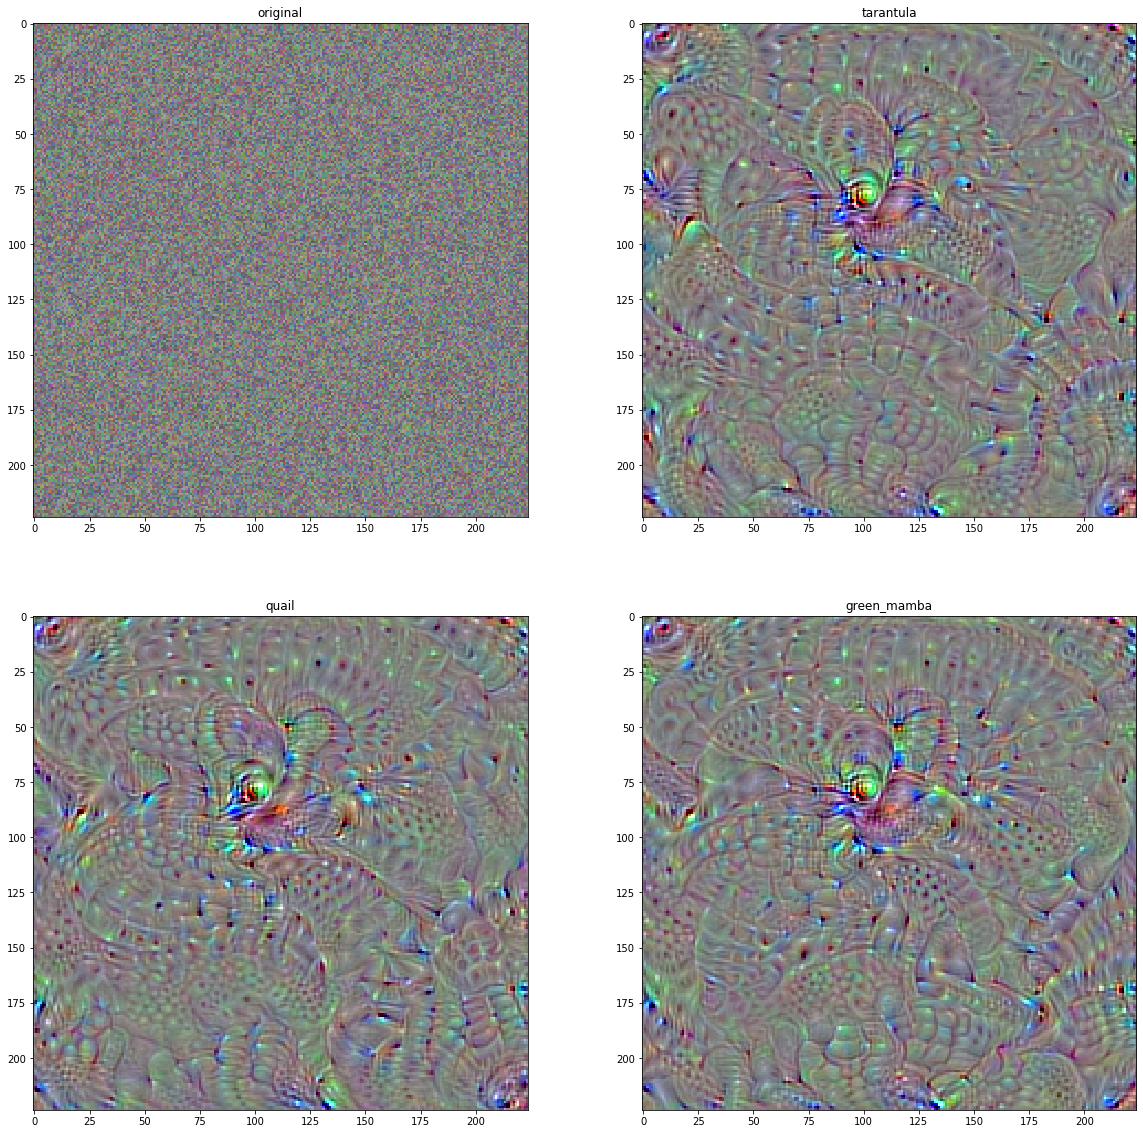

In [41]:
# Let's try this with a couple of other common object types.
fig, ax = plt.subplots(2,2,figsize=(20, 20))

#ax.flatten()

ax[0,0].imshow(deprocess_image(input_img_data.reshape(224,224,3)))
ax[0,0].set_title('original')

named_objs = ['tarantula', 'quail', 'green_mamba']
for i,obj in enumerate(named_objs):
    out_index = vgg16_dict[obj]
    print(out_index)

    iter = 20
    final_img = iterate_grads(vgg,  layer_dict, out_index, iter, input_img_data)
    if i==0:
        ax[0,1].imshow(deprocess_image(final_img.reshape(224,224,3)))
        ax[0,1].set_title(obj)
    elif i==1:
        ax[1,0].imshow(deprocess_image(final_img.reshape(224,224,3)))
        ax[1,0].set_title(obj)
    else:
        ax[1,1].imshow(deprocess_image(final_img.reshape(224,224,3)))
        ax[1,1].set_title(obj)
        

fig.show()

In [ ]:
# Using L_2 loss instead...